# Compare explicit calculations to numerical calculations in CGL model

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is

import nBodyCoupling as nb

import cgl3

import lib

from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from scipy.integrate import solve_ivp

import scipy as sp
from scipy.optimize import root,bisect

import copy

from sympy.utilities.lambdify import lambdify, implemented_function
imp_fn = implemented_function

#from sympy import init_printing

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

In [2]:
reload(cgl3);reload(nb)
nbc = nb.nBodyCoupling

# sym.init_printing(pretty_print=True,wrap_line=True)

In [3]:
var_names = ['x','y']

pardict = {'q_val':1,
           'eps_val':0,
           'd_val':.9,
           'sig_val':.1,
           'rho_val':.15,
           'mu_val':1}

In [4]:
pdict = {}
for key in pardict.keys():
    key2 = key[:-4]
    pdict[key2] = pardict[key]

kwargs = {'recompute_list':[],#['k_sym','p_sym'],
          
          'g_forward':False,
          'i_forward':False,
          'z_forward':False,
          'dense':True,

          'N':3,
          'coupling_mat':cgl3.coupling_mat,
          
          'dir':'data/dat_cgl3/',
          
          'max_n':-1,
          'trunc_order':2,
          'trunc_deriv':1,
          'NA':101,
          'NG':101,
          'gij_parallel':False,
          'p_iter':5,
          'TN':5000,
          'rtol':1e-8,
          'atol':1e-8,
          'rel_tol':1e-6,
          'method':'LSODA',
          'load_all':True,
          'plot':False,
          'log_level':'CRITICAL',
          'chunksize':1000}

T_init = 2*np.pi
lc_init = np.array([1,0,T_init])

# for NIC, 3rd derivatives go away, so we only need trunc_gh=3.
a = nbc(cgl3.rhs,cgl3.coupling,lc_init,var_names,pardict,**kwargs)

a Matrix([[a00, a01, a02], [a10, a11, a12], [a20, a21, a22]])
* Floquet Exponent kappa =-0.1999999999999741
eigenvectors[[-5.54701376e-01  1.41837718e-06]
 [ 8.32049508e-01 -1.00000000e+00]]
g1_init[-0.55470138  0.83204951]
z0_init[-1.49999858 -1.00000213]
i0_init[-1.80277564e+00 -2.55701582e-06]
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...
* Loading K symbolic...
* Loading p symbolic...
* Loading H symbolic...


# Check Fourier

# If all functions have no constant and no higher-order Fourier series, then we can take sin and cos for each integral.

In [5]:
# print(a.i['dat'][2])

(-1000.0, 1000.0)

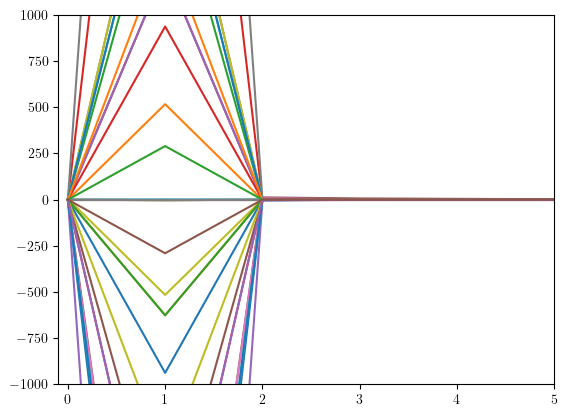

In [6]:
fig,axs = plt.subplots()

fnlist = [a.i,a.z,a.g]

for j in range(3):
    for k in range(a.miter):
    
        outx = np.fft.fft(fnlist[j]['dat'][k][:,0])
        outy = np.fft.fft(fnlist[j]['dat'][k][:,1])

        nyq = int(len(outx)/2)
        if np.sum(np.abs(outx[2:nyq])>50)>0:
            print('found large index for fn',fnlist[j]['x_eps_fname'],'order',k)

            print(outx[2:nyq][outx[2:nyq]>50])

        if np.sum(np.abs(outy[2:nyq])>50)>0:
            print('found large index for fn',fnlist[j]['x_eps_fname'],'order',k)

            print(outy[2:nyq][outy[2:nyq]>50])
        
        axs.plot(outx.real)
        axs.plot(outx.imag)
        axs.plot(outy.real)
        axs.plot(outy.imag)

axs.set_xlim(-.1,5)
axs.set_ylim(-1000,1000)

# It seems like the smallest nontrivial magnitude is on the order of 250 (non-normalized).

Thresholding at a magnitude of 50 (above) shows that there are no other higher-order terms.

So we shall express terms like $g^{(k)}(\theta_i) = [a_g^{(k)} \exp(i \theta_i) + \bar{a}_g^{(k)} \exp(-i \theta_i),b_g^{(k)} \exp(i \theta_i)]^T$

Each function $g_i$ has one Fourier coefficient per coordinate.

In [7]:
var_names

['x', 'y']

In [8]:
im = sym.I # imaginary

In [9]:
t_sym = a.t#sym.symbols('t',real=True)

In [10]:
ths = a.ths#sym.symbols('theta_0 theta_1 theta_2', real=True)

In [11]:
pds = a.pardict_sym
print(pds)

{'q': q, 'eps': eps, 'd': d, 'sig': sig, 'rho': rho, 'mu': mu}


In [12]:
rule_fourier = {}

consts = ['a','b']
consts2 = ['aj','bj']

for i in range(a.N):
    for k in range(a.miter):
        for ell in range(len(var_names)):
            term1 = sym.Indexed(consts[ell]+'I',k)*sym.exp(im*(ths[i]-t_sym))
            #term2 = sym.Indexed(consts2[ell]+'I',k)*sym.exp(-im*(ths[i]-t_sym))
            rule_fourier[sym.Indexed('i'+var_names[ell]+str(i),k)] = term1 + sym.conjugate(term1)

for i in range(a.N):
    for k in range(a.miter):
        for ell in range(len(var_names)):
            term1 = sym.Indexed(consts[ell]+'Z',k)*sym.exp(im*(ths[i]-t_sym))
            term2= sym.Indexed(consts2[ell]+'Z',k)*sym.exp(-im*(ths[i]-t_sym))
            rule_fourier[sym.Indexed('z'+var_names[ell]+str(i),k)] = term1 + sym.conjugate(term1)
for i in range(a.N):
    for k in range(a.miter):
        for ell in range(len(var_names)):
            term1 = sym.Indexed(consts[ell]+'g',k)*sym.exp(im*(ths[i]-t_sym))
            term2= sym.Indexed(consts2[ell]+'g',k)*sym.exp(-im*(ths[i]-t_sym))
            rule_fourier[sym.Indexed('g'+var_names[ell]+str(i),k)] = term1 + sym.conjugate(term1)

for i in range(a.N):
    for ell in range(len(var_names)):
        term1 = sym.symbols(consts[ell]+'L')*sym.exp(im*(ths[i]-t_sym))
        term2= sym.symbols(consts2[ell]+'L')*sym.exp(-im*(ths[i]-t_sym))
        rule_fourier[sym.symbols(var_names[ell]+str(i))] = term1 + sym.conjugate(term1)

#rule_fourier[sym.symbols('cx')] = 1/2
#rule_fourier[sym.symbols('cy')] = -im/2

#rule_fourier[sym.symbols('cjx')] = 1/2
#rule_fourier[sym.symbols('cjy')] = im/2

In [13]:
rule_fourier

{ix0[0]: exp(I*(-t + th0))*aI[0] + exp(-I*(-t + th0))*conjugate(aI[0]),
 iy0[0]: exp(I*(-t + th0))*bI[0] + exp(-I*(-t + th0))*conjugate(bI[0]),
 ix0[1]: exp(I*(-t + th0))*aI[1] + exp(-I*(-t + th0))*conjugate(aI[1]),
 iy0[1]: exp(I*(-t + th0))*bI[1] + exp(-I*(-t + th0))*conjugate(bI[1]),
 ix0[2]: exp(I*(-t + th0))*aI[2] + exp(-I*(-t + th0))*conjugate(aI[2]),
 iy0[2]: exp(I*(-t + th0))*bI[2] + exp(-I*(-t + th0))*conjugate(bI[2]),
 ix1[0]: exp(I*(-t + th1))*aI[0] + exp(-I*(-t + th1))*conjugate(aI[0]),
 iy1[0]: exp(I*(-t + th1))*bI[0] + exp(-I*(-t + th1))*conjugate(bI[0]),
 ix1[1]: exp(I*(-t + th1))*aI[1] + exp(-I*(-t + th1))*conjugate(aI[1]),
 iy1[1]: exp(I*(-t + th1))*bI[1] + exp(-I*(-t + th1))*conjugate(bI[1]),
 ix1[2]: exp(I*(-t + th1))*aI[2] + exp(-I*(-t + th1))*conjugate(aI[2]),
 iy1[2]: exp(I*(-t + th1))*bI[2] + exp(-I*(-t + th1))*conjugate(bI[2]),
 ix2[0]: exp(I*(-t + th2))*aI[0] + exp(-I*(-t + th2))*conjugate(aI[0]),
 iy2[0]: exp(I*(-t + th2))*bI[0] + exp(-I*(-t + th2))*conjugate(

Due to symmetry, we also have the following rules

In [14]:
rule_fourier2 = {}


for k in range(a.miter):
    rule_fourier2[sym.Indexed(consts[1]+'I',k)] = -im*sym.Indexed(consts[0]+'I',k)
    rule_fourier2[sym.Indexed(consts[1]+'Z',k)] = -im*sym.Indexed(consts[0]+'Z',k)
    rule_fourier2[sym.Indexed(consts[1]+'g',k)] = -im*sym.Indexed(consts[0]+'g',k)

rule_fourier2[sym.symbols(consts[1]+'L')] = -im*sym.symbols(consts[0]+'L')


In [15]:
rule_fourier2

{bI[0]: -I*aI[0],
 bZ[0]: -I*aZ[0],
 bg[0]: -I*ag[0],
 bI[1]: -I*aI[1],
 bZ[1]: -I*aZ[1],
 bg[1]: -I*ag[1],
 bI[2]: -I*aI[2],
 bZ[2]: -I*aZ[2],
 bg[2]: -I*ag[2],
 bL: -I*aL}

In [16]:
rule = {**a.rule_lc['glo'],**a.rule_i['glo'],
        **a.rule_g['glo'],
        **a.rule_par,**a.rule_pg}

# p_i functions

In [17]:
kappa2 = sym.symbols('kappa_2',negative=True)
kappa2

kappa_2

## Order 1

In [18]:
a.p['sym'][0,1,1]

-a01*d*x0*iy0[0] + a01*d*x1*iy0[0] + a01*d*y0*ix0[0] - a01*d*y1*ix0[0] - a01*x0*ix0[0] + a01*x1*ix0[0] - a01*y0*iy0[0] + a01*y1*iy0[0]

In [19]:
# p_1^{(1)}
# print(a.p['sym'][0,1,1])
# print('')
# print(a.p['sym'][0,1,1].subs(rule_fourier))
p11_forcing = (a.p['sym'][0,1,1] + a.p['sym'][0,2,1]).subs(rule_fourier).subs(rule_fourier2)
p21_forcing = (a.p['sym'][1,0,1] + a.p['sym'][1,2,1]).subs(rule_fourier).subs(rule_fourier2)
p31_forcing = (a.p['sym'][2,0,1] + a.p['sym'][2,1,1]).subs(rule_fourier).subs(rule_fourier2)

p11_integrand = sym.exp(kappa2*t_sym)*p11_forcing
p21_integrand = sym.exp(kappa2*t_sym)*p21_forcing
p31_integrand = sym.exp(kappa2*t_sym)*p31_forcing
print('')
#print(sym.powsimp(p11_integrand))

p11_integrand
#print(p31_integrand)

(-a01*d*(aL*exp(I*(-t + th0)) + exp(-I*(-t + th0))*conjugate(aL))*(-I*exp(I*(-t + th0))*aI[0] + I*exp(-I*(-t + th0))*conjugate(aI[0])) + a01*d*(aL*exp(I*(-t + th1)) + exp(-I*(-t + th1))*conjugate(aL))*(-I*exp(I*(-t + th0))*aI[0] + I*exp(-I*(-t + th0))*conjugate(aI[0])) + a01*d*(exp(I*(-t + th0))*aI[0] + exp(-I*(-t + th0))*conjugate(aI[0]))*(-I*aL*exp(I*(-t + th0)) + I*exp(-I*(-t + th0))*conjugate(aL)) - a01*d*(exp(I*(-t + th0))*aI[0] + exp(-I*(-t + th0))*conjugate(aI[0]))*(-I*aL*exp(I*(-t + th1)) + I*exp(-I*(-t + th1))*conjugate(aL)) - a01*(aL*exp(I*(-t + th0)) + exp(-I*(-t + th0))*conjugate(aL))*(exp(I*(-t + th0))*aI[0] + exp(-I*(-t + th0))*conjugate(aI[0])) + a01*(aL*exp(I*(-t + th1)) + exp(-I*(-t + th1))*conjugate(aL))*(exp(I*(-t + th0))*aI[0] + exp(-I*(-t + th0))*conjugate(aI[0])) - a01*(-I*aL*exp(I*(-t + th0)) + I*exp(-I*(-t + th0))*conjugate(aL))*(-I*exp(I*(-t + th0))*aI[0] + I*exp(-I*(-t + th0))*conjugate(aI[0])) + a01*(-I*aL*exp(I*(-t + th1)) + I*exp(-I*(-t + th1))*conjugate(aL

### Integrals

In [20]:
#print('')
p11_unsimp = sym.integrate(p11_integrand,(t_sym,0,sym.oo))
p21_unsimp = sym.integrate(p21_integrand,(t_sym,0,sym.oo))
p31_unsimp = sym.integrate(p31_integrand,(t_sym,0,sym.oo))

p11_unsimp

2*I*a01*aL*d*conjugate(aI[0])/kappa_2 - 2*I*a01*aL*d*exp(-I*th0)*exp(I*th1)*conjugate(aI[0])/kappa_2 + 2*a01*aL*conjugate(aI[0])/kappa_2 - 2*a01*aL*exp(-I*th0)*exp(I*th1)*conjugate(aI[0])/kappa_2 + 2*I*a01*d*exp(I*th0)*exp(-I*th1)*conjugate(aL)*aI[0]/kappa_2 - 2*I*a01*d*conjugate(aL)*aI[0]/kappa_2 - 2*a01*exp(I*th0)*exp(-I*th1)*conjugate(aL)*aI[0]/kappa_2 + 2*a01*conjugate(aL)*aI[0]/kappa_2 + 2*I*a02*aL*d*conjugate(aI[0])/kappa_2 - 2*I*a02*aL*d*exp(-I*th0)*exp(I*th2)*conjugate(aI[0])/kappa_2 + 2*a02*aL*conjugate(aI[0])/kappa_2 - 2*a02*aL*exp(-I*th0)*exp(I*th2)*conjugate(aI[0])/kappa_2 + 2*I*a02*d*exp(I*th0)*exp(-I*th2)*conjugate(aL)*aI[0]/kappa_2 - 2*I*a02*d*conjugate(aL)*aI[0]/kappa_2 - 2*a02*exp(I*th0)*exp(-I*th2)*conjugate(aL)*aI[0]/kappa_2 + 2*a02*conjugate(aL)*aI[0]/kappa_2

In [21]:
# p11 = sym.collect(sym.powsimp(p11_unsimp),[sym.exp(im*a.ths[0]),sym.exp(im*a.ths[1]),sym.exp(im*a.ths[2]),sym.exp(im*(a.ths[0]+a.ths[2])),sym.exp(im*(a.ths[0]+a.ths[1]))])
# p21 = sym.collect(sym.powsimp(p21_unsimp),[sym.exp(im*a.ths[0]),sym.exp(im*a.ths[1]),sym.exp(im*a.ths[2]),sym.exp(im*(a.ths[1]+a.ths[0])),sym.exp(im*(a.ths[1]+a.ths[2]))])
# p31 = sym.collect(sym.powsimp(p31_unsimp),[sym.exp(im*a.ths[0]),sym.exp(im*a.ths[1]),sym.exp(im*a.ths[2]),sym.exp(im*(a.ths[2]+a.ths[0])),sym.exp(im*(a.ths[2]+a.ths[1]))])

In [22]:
p11 = p11_unsimp
p21 = p21_unsimp
p31 = p31_unsimp

In [23]:
# p21

In [24]:
# p31

## Collect and simplify

In [25]:
p11_next = copy.deepcopy(p11)
p21_next = copy.deepcopy(p21)
p31_next = copy.deepcopy(p31)

#for i in range(len(a.ths)):
#    p11_next = p11_next.subs({a.ths[i]:a.ths[i]-a.t})
#    p21_next = p21_next.subs({a.ths[i]:a.ths[i]-a.t})
#    p31_next = p31_next.subs({a.ths[i]:a.ths[i]-a.t})

In [26]:
print(a.cmat)

Matrix([[a00, a01, a02], [a10, a11, a12], [a20, a21, a22]])


In [27]:
p11_check = sym.collect(p11_next,[a.cmat[0,1],a.cmat[0,2]])
p21_check = sym.collect(p21_next,[a.cmat[1,0],a.cmat[1,2]])
p31_check = sym.collect(p31_next,[a.cmat[2,1],a.cmat[2,0]])

p11_check = sym.powsimp(p11_check)
p21_check = sym.powsimp(p21_check)
p31_check = sym.powsimp(p31_check)

In [28]:
p11_check

a01*(-2*I*aL*d*exp(I*(-th0 + th1))*conjugate(aI[0])/kappa_2 + 2*I*aL*d*conjugate(aI[0])/kappa_2 - 2*aL*exp(I*(-th0 + th1))*conjugate(aI[0])/kappa_2 + 2*aL*conjugate(aI[0])/kappa_2 + 2*I*d*exp(I*(th0 - th1))*conjugate(aL)*aI[0]/kappa_2 - 2*I*d*conjugate(aL)*aI[0]/kappa_2 - 2*exp(I*(th0 - th1))*conjugate(aL)*aI[0]/kappa_2 + 2*conjugate(aL)*aI[0]/kappa_2) + a02*(-2*I*aL*d*exp(I*(-th0 + th2))*conjugate(aI[0])/kappa_2 + 2*I*aL*d*conjugate(aI[0])/kappa_2 - 2*aL*exp(I*(-th0 + th2))*conjugate(aI[0])/kappa_2 + 2*aL*conjugate(aI[0])/kappa_2 + 2*I*d*exp(I*(th0 - th2))*conjugate(aL)*aI[0]/kappa_2 - 2*I*d*conjugate(aL)*aI[0]/kappa_2 - 2*exp(I*(th0 - th2))*conjugate(aL)*aI[0]/kappa_2 + 2*conjugate(aL)*aI[0]/kappa_2)

In [29]:
print(p11_check) # put this into mathematica.

a01*(-2*I*aL*d*exp(I*(-th0 + th1))*conjugate(aI[0])/kappa_2 + 2*I*aL*d*conjugate(aI[0])/kappa_2 - 2*aL*exp(I*(-th0 + th1))*conjugate(aI[0])/kappa_2 + 2*aL*conjugate(aI[0])/kappa_2 + 2*I*d*exp(I*(th0 - th1))*conjugate(aL)*aI[0]/kappa_2 - 2*I*d*conjugate(aL)*aI[0]/kappa_2 - 2*exp(I*(th0 - th1))*conjugate(aL)*aI[0]/kappa_2 + 2*conjugate(aL)*aI[0]/kappa_2) + a02*(-2*I*aL*d*exp(I*(-th0 + th2))*conjugate(aI[0])/kappa_2 + 2*I*aL*d*conjugate(aI[0])/kappa_2 - 2*aL*exp(I*(-th0 + th2))*conjugate(aI[0])/kappa_2 + 2*aL*conjugate(aI[0])/kappa_2 + 2*I*d*exp(I*(th0 - th2))*conjugate(aL)*aI[0]/kappa_2 - 2*I*d*conjugate(aL)*aI[0]/kappa_2 - 2*exp(I*(th0 - th2))*conjugate(aL)*aI[0]/kappa_2 + 2*conjugate(aL)*aI[0]/kappa_2)


## Order 2

In [30]:
a1 = sym.symbols('c1',complex=True)

### Manual order 1 functions

In [31]:
# just rewrite the order 1 functions.
p11_next2 = 0
p21_next2 = 0
p31_next2 = 0

for j in range(a.N):
    p11_next2 += a1* a.cmat[0,j] * (1-sym.exp(-im*(a.ths[j]-a.ths[0])))
    p21_next2 += a1* a.cmat[1,j] * (1-sym.exp(-im*(a.ths[j]-a.ths[1])))
    p31_next2 += a1* a.cmat[2,j] * (1-sym.exp(-im*(a.ths[j]-a.ths[2])))

p11_next2 += sym.conjugate(p11_next2)
p21_next2 += sym.conjugate(p21_next2)
p31_next2 += sym.conjugate(p31_next2)

p11_next2 /= kappa2
p21_next2 /= kappa2
p31_next2 /= kappa2

In [32]:
p11_next2

(a01*c1*(1 - exp(-I*(-th0 + th1))) + a01*(1 - exp(I*(-th0 + th1)))*conjugate(c1) + a02*c1*(1 - exp(-I*(-th0 + th2))) + a02*(1 - exp(I*(-th0 + th2)))*conjugate(c1))/kappa_2

In [33]:
rule_p1 = {sym.Indexed('p',0,1):p11_next2,
           sym.Indexed('p',1,1):p21_next2,
           sym.Indexed('p',2,1):p31_next2}

print(rule_p1)

{p[0, 1]: (a01*c1*(1 - exp(-I*(-th0 + th1))) + a01*(1 - exp(I*(-th0 + th1)))*conjugate(c1) + a02*c1*(1 - exp(-I*(-th0 + th2))) + a02*(1 - exp(I*(-th0 + th2)))*conjugate(c1))/kappa_2, p[1, 1]: (a10*c1*(1 - exp(-I*(th0 - th1))) + a10*(1 - exp(I*(th0 - th1)))*conjugate(c1) + a12*c1*(1 - exp(-I*(-th1 + th2))) + a12*(1 - exp(I*(-th1 + th2)))*conjugate(c1))/kappa_2, p[2, 1]: (a20*c1*(1 - exp(-I*(th0 - th2))) + a20*(1 - exp(I*(th0 - th2)))*conjugate(c1) + a21*c1*(1 - exp(-I*(th1 - th2))) + a21*(1 - exp(I*(th1 - th2)))*conjugate(c1))/kappa_2}


In [34]:
# p_1^{(2)}

p12_forcing = (a.p['sym'][0,1,2] + a.p['sym'][0,2,2]).subs(rule_fourier).subs(rule_fourier2).subs(rule_p1)
p22_forcing = (a.p['sym'][1,0,2] + a.p['sym'][1,2,2]).subs(rule_fourier).subs(rule_fourier2).subs(rule_p1)
p32_forcing = (a.p['sym'][2,0,2] + a.p['sym'][2,1,2]).subs(rule_fourier).subs(rule_fourier2).subs(rule_p1)

p12_forcing

-a01*d*(aL*exp(I*(-t + th0)) + exp(-I*(-t + th0))*conjugate(aL))*(-I*exp(I*(-t + th0))*aI[1] + I*exp(-I*(-t + th0))*conjugate(aI[1]))*(a01*c1*(1 - exp(-I*(-th0 + th1))) + a01*(1 - exp(I*(-th0 + th1)))*conjugate(c1) + a02*c1*(1 - exp(-I*(-th0 + th2))) + a02*(1 - exp(I*(-th0 + th2)))*conjugate(c1))/kappa_2 + a01*d*(aL*exp(I*(-t + th1)) + exp(-I*(-t + th1))*conjugate(aL))*(-I*exp(I*(-t + th0))*aI[1] + I*exp(-I*(-t + th0))*conjugate(aI[1]))*(a01*c1*(1 - exp(-I*(-th0 + th1))) + a01*(1 - exp(I*(-th0 + th1)))*conjugate(c1) + a02*c1*(1 - exp(-I*(-th0 + th2))) + a02*(1 - exp(I*(-th0 + th2)))*conjugate(c1))/kappa_2 + a01*d*(exp(I*(-t + th0))*aI[0] + exp(-I*(-t + th0))*conjugate(aI[0]))*(-I*exp(I*(-t + th0))*ag[1] + I*exp(-I*(-t + th0))*conjugate(ag[1]))*(a01*c1*(1 - exp(-I*(-th0 + th1))) + a01*(1 - exp(I*(-th0 + th1)))*conjugate(c1) + a02*c1*(1 - exp(-I*(-th0 + th2))) + a02*(1 - exp(I*(-th0 + th2)))*conjugate(c1))/kappa_2 - a01*d*(exp(I*(-t + th0))*aI[0] + exp(-I*(-t + th0))*conjugate(aI[0]))*(-

In [35]:
p12_integrand = sym.exp(kappa2*a.t)*p12_forcing
p22_integrand = sym.exp(kappa2*a.t)*p22_forcing
p32_integrand = sym.exp(kappa2*a.t)*p32_forcing

In [36]:
p12_unsimp = sym.integrate(p12_integrand,(a.t,0,sym.oo))
p22_unsimp = sym.integrate(p22_integrand,(a.t,0,sym.oo))
p32_unsimp = sym.integrate(p32_integrand,(a.t,0,sym.oo))

In [37]:
p12_check = sym.collect(p12_unsimp,[a.cmat[0,1]**2,a.cmat[0,2]**2,a.cmat[0,1]*a.cmat[0,2],a.cmat[0,1]*a.cmat[1,0],a.cmat[0,2]*a.cmat[2,0],a.cmat[0,2]*a.cmat[2,1],a.cmat[0,1]*a.cmat[1,2]])
p22_check = sym.collect(p22_unsimp,[a.cmat[1,1]*a.cmat[1,2],a.cmat[1,0]*a.cmat[0,1],a.cmat[1,2]*a.cmat[2,0],a.cmat[1,2]*a.cmat[2,1],a.cmat[1,1]*a.cmat[1,2]])
p32_check = sym.collect(p32_unsimp,[a.cmat[2,1]*a.cmat[2,0],a.cmat[2,1]*a.cmat[1,0],a.cmat[2,0]*a.cmat[2,0],a.cmat[2,0]*a.cmat[2,1],a.cmat[2,1]*a.cmat[1,2]])

#p12_check = sym.powsimp(p12_check)
#p12_check = sym.collect(p12_check,[sym.exp(im*(-ths[0]+ths[1])),sym.exp(im*(ths[0]-ths[1]))])
#sym.pprint(p12_check,num_columns=130)
#print(p12_check)

In [38]:
print(p12_check)

a01**2*(-2*I*aL*c1*d*exp(I*th0)*exp(-I*th1)*conjugate(aI[1])/kappa_2**2 + 4*I*aL*c1*d*conjugate(aI[1])/kappa_2**2 - 2*I*aL*c1*d*exp(-I*th0)*exp(I*th1)*conjugate(aI[1])/kappa_2**2 - 2*aL*c1*exp(I*th0)*exp(-I*th1)*conjugate(aI[1])/kappa_2**2 + 4*aL*c1*conjugate(aI[1])/kappa_2**2 - 2*aL*c1*exp(-I*th0)*exp(I*th1)*conjugate(aI[1])/kappa_2**2 + 2*I*aL*d*conjugate(c1)*conjugate(aI[1])/kappa_2**2 - 4*I*aL*d*exp(-I*th0)*exp(I*th1)*conjugate(c1)*conjugate(aI[1])/kappa_2**2 + 2*I*aL*d*exp(-2*I*th0)*exp(2*I*th1)*conjugate(c1)*conjugate(aI[1])/kappa_2**2 + 2*aL*conjugate(c1)*conjugate(aI[1])/kappa_2**2 - 4*aL*exp(-I*th0)*exp(I*th1)*conjugate(c1)*conjugate(aI[1])/kappa_2**2 + 2*aL*exp(-2*I*th0)*exp(2*I*th1)*conjugate(c1)*conjugate(aI[1])/kappa_2**2 - 2*I*c1*d*exp(2*I*th0)*exp(-2*I*th1)*conjugate(aL)*aI[1]/kappa_2**2 + 4*I*c1*d*exp(I*th0)*exp(-I*th1)*conjugate(aL)*aI[1]/kappa_2**2 - 2*I*c1*d*exp(I*th0)*exp(-I*th1)*conjugate(aI[0])*ag[1]/kappa_2**2 + 2*I*c1*d*exp(I*th0)*exp(-I*th1)*conjugate(ag[1])*aI

In [39]:
# rule_p2 = {sym.Indexed('p',0,2):p12_check,
#            sym.Indexed('p',1,2):p22_check,
#            sym.Indexed('p',2,2):p32_check}

In [40]:
# terms1 = [sym.exp(im*a.ths[0]),sym.exp(im*a.ths[1]),sym.exp(im*a.ths[2]),
#          sym.exp(im*(a.ths[0]+a.ths[2])),sym.exp(im*(a.ths[0]+a.ths[1])),
#          sym.exp(im*(3*a.ths[0]+a.ths[1])),sym.exp(im*(a.ths[0]+3*a.ths[1])),
#         sym.exp(im*(3*a.ths[0]+a.ths[2])),sym.exp(im*(a.ths[0]+3*a.ths[2])),
#         sym.exp(im*(2*a.ths[0]+a.ths[1]+a.ths[2])),sym.exp(im*(a.ths[0]+2*a.ths[1]+a.ths[2])),sym.exp(im*(a.ths[0]+a.ths[1]+2*a.ths[2]))]
# terms2 = [sym.exp(im*a.ths[0]),sym.exp(im*a.ths[1]),sym.exp(im*a.ths[2]),
#          sym.exp(im*(a.ths[1]+a.ths[2])),sym.exp(im*(a.ths[1]+a.ths[0])),
#          sym.exp(im*(3*a.ths[1]+a.ths[2])),sym.exp(im*(a.ths[1]+3*a.ths[2])),
#         sym.exp(im*(3*a.ths[1]+a.ths[0])),sym.exp(im*(a.ths[1]+3*a.ths[0])),
#         sym.exp(im*(2*a.ths[1]+a.ths[2]+a.ths[0])),sym.exp(im*(a.ths[1]+2*a.ths[2]+a.ths[0])),sym.exp(im*(a.ths[1]+a.ths[2]+2*a.ths[0]))]
# terms3 = [sym.exp(im*a.ths[0]),sym.exp(im*a.ths[1]),sym.exp(im*a.ths[2]),
#          sym.exp(im*(a.ths[2]+a.ths[0])),sym.exp(im*(a.ths[2]+a.ths[1])),
#          sym.exp(im*(3*a.ths[2]+a.ths[1])),sym.exp(im*(a.ths[2]+3*a.ths[1])),
#         sym.exp(im*(3*a.ths[2]+a.ths[0])),sym.exp(im*(a.ths[2]+3*a.ths[0])),
#         sym.exp(im*(2*a.ths[2]+a.ths[1]+a.ths[0])),sym.exp(im*(a.ths[2]+2*a.ths[1]+a.ths[0])),sym.exp(im*(a.ths[2]+a.ths[1]+2*a.ths[0]))]

# p12 = sym.cancel((kappa2*(1-4*im/kappa2))*p12_unsimp/a1)#sym.collect(sym.powsimp(p12_unsimp),terms1)
# p22 = p22_unsimp#sym.collect(sym.powsimp(p22_unsimp),terms2)
# p32 = p32_unsimp#sym.collect(sym.powsimp(p32_unsimp),terms3)

# p12 = sym.collect(p12,[a.cmat[0,1],a.cmat[0,2],a.cmat[0,1]*a.cmat[1,0],a.cmat[0,1]*a.cmat[0,2],a.cmat[0,2]*a.cmat[2,1],a.cmat[0,1]*a.cmat[1,2],a.cmat[0,2]*a.cmat[2,0]])
# p22 = sym.collect(p22,kappa2)
# p32 = sym.collect(p32,kappa2)

# be1 = sym.symbols('beta1')

# #rule_pattern = {sym.Indexed('a'+'I',0)*sym.Indexed('b'+'g',1)*sym.symbols('d')-sym.Indexed('b'+'I',0)*sym.Indexed('a'+'g',1)*sym.symbols('d'):be1}
# rule_pattern = {sym.symbols('aL')*sym.symbols('d')*sym.Indexed('b'+'I',1)-sym.symbols('bL')*sym.Indexed('b'+'I',1):be1}
# terms2 = [sym.symbols('aL')*sym.symbols('d')*sym.Indexed('b'+'I',1),
#           sym.symbols('bL')*sym.symbols('d')*sym.Indexed('a'+'I',1),
#           sym.symbols('d')*sym.Indexed('a'+'I',0)*sym.Indexed('b'+'g',1),
#           sym.symbols('d')*sym.Indexed('b'+'I',0)*sym.Indexed('a'+'g',1),
#           sym.symbols('bL')*sym.Indexed('b'+'I',1),sym.symbols('bL')*sym.Indexed('b'+'I',1),
#           sym.symbols('aL')*sym.Indexed('a'+'I',1),
#           sym.Indexed('a'+'I',0)*sym.Indexed('a'+'g',1),
#           sym.Indexed('b'+'I',0)*sym.Indexed('b'+'g',1)]
# p12_check = sym.collect(p12,terms2)
# #p12.subs(rule_pattern)

# sym.powsimp(p12_check)

# # p12_check.subs({:'})
# rule_sub_brute = {-sym.exp(4*im*a.ths[0])+2*sym.exp(im*(3*a.ths[0]+a.ths[1]))-  sym.exp(2*im*(a.ths[0]+a.ths[1])):'f1',
#                    sym.exp(4*im*a.ths[0])-2*sym.exp(im*(3*a.ths[0]+a.ths[1]))+  sym.exp(2*im*a.ths[0]+2*im*a.ths[1]):'f2',
#                  }


# H

## eps

In [41]:
a.recompute_list = ['h_sym']
a.load_h_sym()

* Computing H symbolic...


In [42]:
rule_time = {-t_sym:t_sym} # change -t to +t

In [43]:
h10 = a.h['sym'][0,0].subs(rule_fourier).subs(rule_fourier2).subs(rule_time)
h20 = a.h['sym'][1,0].subs(rule_fourier).subs(rule_fourier2).subs(rule_time)
h30 = a.h['sym'][2,0].subs(rule_fourier).subs(rule_fourier2).subs(rule_time)
h10

-a01*d*(aL*exp(I*(t + th0)) + exp(-I*(t + th0))*conjugate(aL))*(-I*exp(I*(t + th0))*aZ[0] + I*exp(-I*(t + th0))*conjugate(aZ[0])) + a01*d*(aL*exp(I*(t + th1)) + exp(-I*(t + th1))*conjugate(aL))*(-I*exp(I*(t + th0))*aZ[0] + I*exp(-I*(t + th0))*conjugate(aZ[0])) + a01*d*(exp(I*(t + th0))*aZ[0] + exp(-I*(t + th0))*conjugate(aZ[0]))*(-I*aL*exp(I*(t + th0)) + I*exp(-I*(t + th0))*conjugate(aL)) - a01*d*(exp(I*(t + th0))*aZ[0] + exp(-I*(t + th0))*conjugate(aZ[0]))*(-I*aL*exp(I*(t + th1)) + I*exp(-I*(t + th1))*conjugate(aL)) - a01*(aL*exp(I*(t + th0)) + exp(-I*(t + th0))*conjugate(aL))*(exp(I*(t + th0))*aZ[0] + exp(-I*(t + th0))*conjugate(aZ[0])) + a01*(aL*exp(I*(t + th1)) + exp(-I*(t + th1))*conjugate(aL))*(exp(I*(t + th0))*aZ[0] + exp(-I*(t + th0))*conjugate(aZ[0])) - a01*(-I*aL*exp(I*(t + th0)) + I*exp(-I*(t + th0))*conjugate(aL))*(-I*exp(I*(t + th0))*aZ[0] + I*exp(-I*(t + th0))*conjugate(aZ[0])) + a01*(-I*aL*exp(I*(t + th1)) + I*exp(-I*(t + th1))*conjugate(aL))*(-I*exp(I*(t + th0))*aZ[0] +

### Integrals

In [44]:
#print('')
h10_unsimp = sym.integrate(h10,(t_sym,0,2*sym.pi))/(2*sym.pi)
h20_unsimp = sym.integrate(h20,(t_sym,0,2*sym.pi))/(2*sym.pi)
h30_unsimp = sym.integrate(h30,(t_sym,0,2*sym.pi))/(2*sym.pi)

h10_unsimp

-2*I*a01*aL*d*conjugate(aZ[0]) + 2*I*a01*aL*d*exp(-I*th0)*exp(I*th1)*conjugate(aZ[0]) - 2*a01*aL*conjugate(aZ[0]) + 2*a01*aL*exp(-I*th0)*exp(I*th1)*conjugate(aZ[0]) - 2*I*a01*d*exp(I*th0)*exp(-I*th1)*conjugate(aL)*aZ[0] + 2*I*a01*d*conjugate(aL)*aZ[0] + 2*a01*exp(I*th0)*exp(-I*th1)*conjugate(aL)*aZ[0] - 2*a01*conjugate(aL)*aZ[0] - 2*I*a02*aL*d*conjugate(aZ[0]) + 2*I*a02*aL*d*exp(-I*th0)*exp(I*th2)*conjugate(aZ[0]) - 2*a02*aL*conjugate(aZ[0]) + 2*a02*aL*exp(-I*th0)*exp(I*th2)*conjugate(aZ[0]) - 2*I*a02*d*exp(I*th0)*exp(-I*th2)*conjugate(aL)*aZ[0] + 2*I*a02*d*conjugate(aL)*aZ[0] + 2*a02*exp(I*th0)*exp(-I*th2)*conjugate(aL)*aZ[0] - 2*a02*conjugate(aL)*aZ[0]

In [45]:
h10_check = sym.powsimp(sym.collect(h10_unsimp,[a.cmat[0,1],a.cmat[0,2]]))
h10_check

a01*(2*I*aL*d*exp(I*(-th0 + th1))*conjugate(aZ[0]) - 2*I*aL*d*conjugate(aZ[0]) + 2*aL*exp(I*(-th0 + th1))*conjugate(aZ[0]) - 2*aL*conjugate(aZ[0]) - 2*I*d*exp(I*(th0 - th1))*conjugate(aL)*aZ[0] + 2*I*d*conjugate(aL)*aZ[0] + 2*exp(I*(th0 - th1))*conjugate(aL)*aZ[0] - 2*conjugate(aL)*aZ[0]) + a02*(2*I*aL*d*exp(I*(-th0 + th2))*conjugate(aZ[0]) - 2*I*aL*d*conjugate(aZ[0]) + 2*aL*exp(I*(-th0 + th2))*conjugate(aZ[0]) - 2*aL*conjugate(aZ[0]) - 2*I*d*exp(I*(th0 - th2))*conjugate(aL)*aZ[0] + 2*I*d*conjugate(aL)*aZ[0] + 2*exp(I*(th0 - th2))*conjugate(aL)*aZ[0] - 2*conjugate(aL)*aZ[0])

### Simplify

In [46]:
# assuming grouped in terms of coupling constants a_ij...

h10_a = sym.Add.make_args(h10_check) # separate for each coupling constant
h10_ai = sym.Mul.make_args(h10_a[0]) # separate coupling constant from inside term

# now loop over each term
h10_ai_terms = sym.Add.make_args(h10_ai[1])

In [47]:
h10_c = sym.collect(h10_ai[1],[sym.exp(im*(-ths[0]+ths[1])),sym.exp(im*(ths[0]-ths[1]))])
h10_c

-2*I*aL*d*conjugate(aZ[0]) - 2*aL*conjugate(aZ[0]) + 2*I*d*conjugate(aL)*aZ[0] + (2*I*aL*d*conjugate(aZ[0]) + 2*aL*conjugate(aZ[0]))*exp(I*(-th0 + th1)) + (-2*I*d*conjugate(aL)*aZ[0] + 2*conjugate(aL)*aZ[0])*exp(I*(th0 - th1)) - 2*conjugate(aL)*aZ[0]

In [48]:
c1 = sym.symbols('c1',complex=True)

In [49]:
h11_next = 0
h21_next = 0
h31_next = 0

for j in range(a.N):
    h11_next += c1* a.cmat[0,j] * (sym.exp(im*(a.ths[j]-a.ths[0]))-1)
    h21_next += c1* a.cmat[1,j] * (sym.exp(im*(a.ths[j]-a.ths[1]))-1)
    h31_next += c1* a.cmat[2,j] * (sym.exp(im*(a.ths[j]-a.ths[2]))-1)

h11_next += sym.conjugate(h11_next)
h21_next += sym.conjugate(h21_next)
h31_next += sym.conjugate(h31_next)

In [50]:
h11_next

a01*c1*(exp(I*(-th0 + th1)) - 1) + a01*(-1 + exp(-I*(-th0 + th1)))*conjugate(c1) + a02*c1*(exp(I*(-th0 + th2)) - 1) + a02*(-1 + exp(-I*(-th0 + th2)))*conjugate(c1)

## eps^2

In [51]:
h11 = a.h['sym'][0,1].subs(rule_fourier).subs(rule_fourier2).subs(rule_p1).subs(rule_time)
h21 = a.h['sym'][1,1].subs(rule_fourier).subs(rule_fourier2).subs(rule_p1).subs(rule_time)
h31 = a.h['sym'][2,1].subs(rule_fourier).subs(rule_fourier2).subs(rule_p1).subs(rule_time)

In [52]:
h11

-a01*d*(aL*exp(I*(t + th0)) + exp(-I*(t + th0))*conjugate(aL))*(-I*exp(I*(t + th0))*aZ[1] + I*exp(-I*(t + th0))*conjugate(aZ[1]))*(a01*c1*(1 - exp(-I*(-th0 + th1))) + a01*(1 - exp(I*(-th0 + th1)))*conjugate(c1) + a02*c1*(1 - exp(-I*(-th0 + th2))) + a02*(1 - exp(I*(-th0 + th2)))*conjugate(c1))/kappa_2 + a01*d*(aL*exp(I*(t + th1)) + exp(-I*(t + th1))*conjugate(aL))*(-I*exp(I*(t + th0))*aZ[1] + I*exp(-I*(t + th0))*conjugate(aZ[1]))*(a01*c1*(1 - exp(-I*(-th0 + th1))) + a01*(1 - exp(I*(-th0 + th1)))*conjugate(c1) + a02*c1*(1 - exp(-I*(-th0 + th2))) + a02*(1 - exp(I*(-th0 + th2)))*conjugate(c1))/kappa_2 + a01*d*(exp(I*(t + th0))*aZ[0] + exp(-I*(t + th0))*conjugate(aZ[0]))*(-I*exp(I*(t + th0))*ag[1] + I*exp(-I*(t + th0))*conjugate(ag[1]))*(a01*c1*(1 - exp(-I*(-th0 + th1))) + a01*(1 - exp(I*(-th0 + th1)))*conjugate(c1) + a02*c1*(1 - exp(-I*(-th0 + th2))) + a02*(1 - exp(I*(-th0 + th2)))*conjugate(c1))/kappa_2 - a01*d*(exp(I*(t + th0))*aZ[0] + exp(-I*(t + th0))*conjugate(aZ[0]))*(-I*exp(I*(t + t

In [53]:
#print('')
h11_unsimp = sym.integrate(h11,(t_sym,0,2*sym.pi))/(2*sym.pi)
h21_unsimp = sym.integrate(h21,(t_sym,0,2*sym.pi))/(2*sym.pi)
h31_unsimp = sym.integrate(h31,(t_sym,0,2*sym.pi))/(2*sym.pi)

h11_unsimp

2*I*a01**2*aL*c1*d*exp(I*th0)*exp(-I*th1)*conjugate(aZ[1])/kappa_2 - 4*I*a01**2*aL*c1*d*conjugate(aZ[1])/kappa_2 + 2*I*a01**2*aL*c1*d*exp(-I*th0)*exp(I*th1)*conjugate(aZ[1])/kappa_2 + 2*a01**2*aL*c1*exp(I*th0)*exp(-I*th1)*conjugate(aZ[1])/kappa_2 - 4*a01**2*aL*c1*conjugate(aZ[1])/kappa_2 + 2*a01**2*aL*c1*exp(-I*th0)*exp(I*th1)*conjugate(aZ[1])/kappa_2 - 2*I*a01**2*aL*d*conjugate(c1)*conjugate(aZ[1])/kappa_2 + 4*I*a01**2*aL*d*exp(-I*th0)*exp(I*th1)*conjugate(c1)*conjugate(aZ[1])/kappa_2 - 2*I*a01**2*aL*d*exp(-2*I*th0)*exp(2*I*th1)*conjugate(c1)*conjugate(aZ[1])/kappa_2 - 2*a01**2*aL*conjugate(c1)*conjugate(aZ[1])/kappa_2 + 4*a01**2*aL*exp(-I*th0)*exp(I*th1)*conjugate(c1)*conjugate(aZ[1])/kappa_2 - 2*a01**2*aL*exp(-2*I*th0)*exp(2*I*th1)*conjugate(c1)*conjugate(aZ[1])/kappa_2 + 2*I*a01**2*c1*d*exp(2*I*th0)*exp(-2*I*th1)*conjugate(aL)*aZ[1]/kappa_2 - 4*I*a01**2*c1*d*exp(I*th0)*exp(-I*th1)*conjugate(aL)*aZ[1]/kappa_2 + 2*I*a01**2*c1*d*exp(I*th0)*exp(-I*th1)*conjugate(aZ[0])*ag[1]/kappa_2 - 

In [54]:
h11_check = sym.collect(h11_unsimp,[a.cmat[0,1],a.cmat[0,2],a.cmat[0,1]*a.cmat[0,2],a.cmat[0,1]*a.cmat[1,0],a.cmat[0,2]*a.cmat[2,0],a.cmat[0,2]*a.cmat[2,1],a.cmat[0,1]*a.cmat[1,2]])
h21_check = sym.collect(h21_unsimp,[a.cmat[1,0],a.cmat[1,2],a.cmat[1,1]*a.cmat[1,2],a.cmat[1,0]*a.cmat[0,1],a.cmat[1,2]*a.cmat[2,0],a.cmat[1,2]*a.cmat[2,1],a.cmat[1,1]*a.cmat[1,2]])
h31_check = sym.collect(h31_unsimp,[a.cmat[2,0],a.cmat[2,1],a.cmat[2,1]*a.cmat[2,0],a.cmat[2,1]*a.cmat[1,0],a.cmat[2,0]*a.cmat[2,0],a.cmat[2,0]*a.cmat[2,1],a.cmat[2,1]*a.cmat[1,2]])

In [55]:
print(sym.powsimp(h11_check))

a01**2*(2*I*aL*c1*d*exp(I*(-th0 + th1))*conjugate(aZ[1])/kappa_2 + 2*I*aL*c1*d*exp(I*(th0 - th1))*conjugate(aZ[1])/kappa_2 - 4*I*aL*c1*d*conjugate(aZ[1])/kappa_2 + 2*aL*c1*exp(I*(-th0 + th1))*conjugate(aZ[1])/kappa_2 + 2*aL*c1*exp(I*(th0 - th1))*conjugate(aZ[1])/kappa_2 - 4*aL*c1*conjugate(aZ[1])/kappa_2 - 2*I*aL*d*exp(2*I*(-th0 + th1))*conjugate(c1)*conjugate(aZ[1])/kappa_2 + 4*I*aL*d*exp(I*(-th0 + th1))*conjugate(c1)*conjugate(aZ[1])/kappa_2 - 2*I*aL*d*conjugate(c1)*conjugate(aZ[1])/kappa_2 - 2*aL*exp(2*I*(-th0 + th1))*conjugate(c1)*conjugate(aZ[1])/kappa_2 + 4*aL*exp(I*(-th0 + th1))*conjugate(c1)*conjugate(aZ[1])/kappa_2 - 2*aL*conjugate(c1)*conjugate(aZ[1])/kappa_2 + 2*I*c1*d*exp(2*I*(th0 - th1))*conjugate(aL)*aZ[1]/kappa_2 - 4*I*c1*d*exp(I*(th0 - th1))*conjugate(aL)*aZ[1]/kappa_2 + 2*I*c1*d*exp(I*(th0 - th1))*conjugate(aZ[0])*ag[1]/kappa_2 - 2*I*c1*d*exp(I*(th0 - th1))*conjugate(ag[1])*aZ[0]/kappa_2 + 2*I*c1*d*conjugate(aL)*aZ[1]/kappa_2 - 2*I*c1*d*conjugate(aZ[0])*ag[1]/kappa_2 +

# eps^3

In [110]:
h12_step1 = sym.simplify(a.h['sym'][0,2].subs(rule_fourier).subs(rule_fourier2)).subs(rule_p1)
h22_step1 = sym.simplify(a.h['sym'][1,2].subs(rule_fourier).subs(rule_fourier2)).subs(rule_p1)
h32_step1 = sym.simplify(a.h['sym'][2,2].subs(rule_fourier).subs(rule_fourier2)).subs(rule_p1)

In [113]:
h12_step2 = sym.powsimp(h12_step1.subs(rule_p2).subs(rule_time))
h22_step2 = sym.powsimp(h22_step1.subs(rule_p2).subs(rule_time))
h32_step2 = sym.powsimp(h32_step1.subs(rule_p2).subs(rule_time))

In [114]:
h12_unsimp = sym.integrate(h12_step2,(t_sym,0,2*sym.pi))/(2*sym.pi)
h22_unsimp = sym.integrate(h22_step2,(t_sym,0,2*sym.pi))/(2*sym.pi)
h32_unsimp = sym.integrate(h32_step2,(t_sym,0,2*sym.pi))/(2*sym.pi)

In [115]:
h12_check = sym.collect(h12_unsimp,[a.cmat[0,1],a.cmat[0,2],a.cmat[0,1]*a.cmat[0,2],a.cmat[0,1]*a.cmat[1,0],a.cmat[0,2]*a.cmat[2,0],a.cmat[0,2]*a.cmat[2,1],a.cmat[0,1]*a.cmat[1,2]])
# h21_check = sym.collect(h21_unsimp,[a.cmat[1,0],a.cmat[1,2],a.cmat[1,1]*a.cmat[1,2],a.cmat[1,0]*a.cmat[0,1],a.cmat[1,2]*a.cmat[2,0],a.cmat[1,2]*a.cmat[2,1],a.cmat[1,1]*a.cmat[1,2]])
# h31_check = sym.collect(h31_unsimp,[a.cmat[2,0],a.cmat[2,1],a.cmat[2,1]*a.cmat[2,0],a.cmat[2,1]*a.cmat[1,0],a.cmat[2,0]*a.cmat[2,0],a.cmat[2,0]*a.cmat[2,1],a.cmat[2,1]*a.cmat[1,2]])

In [117]:
print(h12_check)

a01*(-2*I*aL*d*(a01*(4*a1*(1 - exp(I*(-th0 + th1))) + 4*(1 - exp(-I*(-th0 + th1)))*conjugate(a1)) + a02*(4*a1*(1 - exp(I*(-th0 + th2))) + 4*(1 - exp(-I*(-th0 + th2)))*conjugate(a1)))**2*exp(I*(-th0 + th1))*conjugate(aZ[2]) + 2*I*aL*d*(a01*(4*a1*(1 - exp(I*(-th0 + th1))) + 4*(1 - exp(-I*(-th0 + th1)))*conjugate(a1)) + a02*(4*a1*(1 - exp(I*(-th0 + th2))) + 4*(1 - exp(-I*(-th0 + th2)))*conjugate(a1)))**2*conjugate(aZ[2]) - 2*I*aL*d*(a01**2*(-8*I*a1*aL*d*exp(2*I*(-th0 + th1))*conjugate(aI[1])/kappa_2 + 16*I*a1*aL*d*exp(I*(-th0 + th1))*conjugate(aI[1])/kappa_2 - 8*I*a1*aL*d*conjugate(aI[1])/kappa_2 + 8*a1*aL*exp(2*I*(-th0 + th1))*conjugate(aI[1])/kappa_2 - 16*a1*aL*exp(I*(-th0 + th1))*conjugate(aI[1])/kappa_2 + 8*a1*aL*conjugate(aI[1])/kappa_2 - 8*I*a1*d*exp(I*(-th0 + th1))*conjugate(aL)*aI[1]/kappa_2 + 8*I*a1*d*exp(I*(-th0 + th1))*conjugate(aI[0])*ag[1]/kappa_2 - 8*I*a1*d*exp(I*(-th0 + th1))*conjugate(ag[1])*aI[0]/kappa_2 - 8*I*a1*d*exp(I*(th0 - th1))*conjugate(aL)*aI[1]/kappa_2 + 16*I*a1*